In [83]:
import pandas as pd

In [84]:
# для нормализации, стандартизации
from sklearn import preprocessing

# Для графиков
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [85]:
hotels = pd.read_csv('hotels.csv')
hotels.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643


## Добавляем пропущенные данные по координатам отелей

In [86]:
# Проверим, что пропуски по геоданным у одних и тех же записей.
# Как видим, мы выбрали данные где одновременно присутствует пропуски по обоим признакам,
# отняли от общего кол-ва записей
hotels[(hotels.lng.isna()) & (hotels.lat.isna())].shape[0] - hotels.shape[0]

-384355

In [87]:
# Сгрупируем по отелям и смотрим у каких отелей отсутствуют геоданные
hotels_with_coor = hotels[hotels.lng.isna() & hotels.lat.isna()].groupby(by = ['hotel_address','hotel_name']).\
  count().iloc[:,0].to_frame().reset_index()
hotels_with_coor.head(2)

,hotel_address,hotel_name,additional_number_of_scoring
0,20 Rue De La Ga t 14th arr 75014 Paris France,Mercure Paris Gare Montparnasse,28
1,23 Rue Damr mont 18th arr 75018 Paris France,Holiday Inn Paris Montmartre,47


In [88]:
# В итоге у нас 17 отелей, не имеющих геоданные.К сожалению, openstreetmap не смог 
# автоматически определить координаты по указанным адресам, и я учитывая небольшое кол-во 
# отелей, сделал это вручную. Сразу замечу, это не обязательно делать, сильно на результат этот признак 
# не влияет и для данного проекта, их можно было заменить например координатами города, или
# из адреса выудить район, где находится отель и посчитать медианные координаты или средние, по
# другим отелям, имеющим координаты из этого района. В вообщем, вариантов, уйма. Что вам больше нравится
hotels_with_coor[['lat','lng']] = 0
hotels_with_coor.loc[0,['lat','lng']] = ['48.8399957','2.3070823']
hotels_with_coor.loc[1,['lat','lng']] = ['48.8889127','2.3309643']
hotels_with_coor.loc[2,['lat','lng']] = ['48.8753208','2.3212033']
hotels_with_coor.loc[3,['lat','lng']] = ['41.391552','2.1757053']
hotels_with_coor.loc[4,['lat','lng']] = ['48.2208555','16.3644228']
hotels_with_coor.loc[5,['lat','lng']] = ['48.233592','16.3434781']
hotels_with_coor.loc[6,['lat','lng']] = ['48.2094054','16.3512565']
hotels_with_coor.loc[7,['lat','lng']] = ['48.2095525','16.3492746']
hotels_with_coor.loc[8,['lat','lng']] = ['48.1888183','16.381591']
hotels_with_coor.loc[9,['lat','lng']] = ['48.1868142','16.418528']
hotels_with_coor.loc[10,['lat','lng']] = ['41.3749946','2.1102353']
hotels_with_coor.loc[11,['lat','lng']] = ['48.219573','16.2834034']
hotels_with_coor.loc[12,['lat','lng']] = ['41.3832425','2.1607609']
hotels_with_coor.loc[13,['lat','lng']] = ['48.2458909','16.3397395']
hotels_with_coor.loc[14,['lat','lng']] = ['48.2135906','16.3777195']
hotels_with_coor.loc[15,['lat','lng']] = ['48.2168032','16.357717']
hotels_with_coor.loc[16,['lat','lng']] = ['48.220414','16.3536299']
# Так как адрес у нас носит уникальный характер (я это соответственно проверил), а название отелей
# есть повторяющиеся, то установим адрес как индекс, для последующего применения метода map
hotels_with_coor.set_index('hotel_address', inplace=True)
hotels_with_coor.head(2)

,hotel_name,additional_number_of_scoring,lat,lng
hotel_address,,,,
20 Rue De La Ga t 14th arr 75014 Paris France,Mercure Paris Gare Montparnasse,28,48.8399957,2.3070823
23 Rue Damr mont 18th arr 75018 Paris France,Holiday Inn Paris Montmartre,47,48.8889127,2.3309643


In [89]:
# Напишем небольшую функцию, для заполнения пропусков в геоданных
def add_missing_coors(address, data_dict):
  """
  Входной параметр адрес, используется для поиска lng, lat в поданном вторым аргументов dataframe.
  Адрес в dataframe является индеком

  Args:
      address (str): строка с адресом отеля
      data_dict (pd.Dataframe()): Dataframe с lng, lat в качестве признаков и адресом в качестве индекса

  Returns:
      pd.Series(): возвращает lng, ltd
  """
  if address in data_dict.index:
      return pd.Series([data_dict.loc[address].lat, data_dict.loc[address].lng],
                     index = ['lat','lng'])

In [90]:
# Работаем только с записями, у которых в наличие пропуски по геоданным, и заполняем пропуски данными в 
# соотвествии с указанными выше геокоординатами
hotels.loc[hotels[(hotels.lat.isna() | hotels.lng.isna())].index,['lat','lng']] = \
hotels[hotels.lat.isna() | hotels.lng.isna()].loc[:].\
  apply(lambda x: add_missing_coors(x.hotel_address, hotels_with_coor), axis = 1)

In [91]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [92]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
X = hotels.drop(['reviewer_score'], axis = 1)  
y = hotels['reviewer_score'] 

In [93]:
# Загружаем специальный инструмент для разбивки:  
from sklearn.model_selection import train_test_split  

In [94]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [95]:
# непрерывные признаки
num_cols = ['total_number_of_reviews', 'review_total_negative_word_counts', 
            'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given',
            'total_number_of_reviews']
# категориальные признаки
cat_cols = ['average_score', 'lat']

<Axes: >

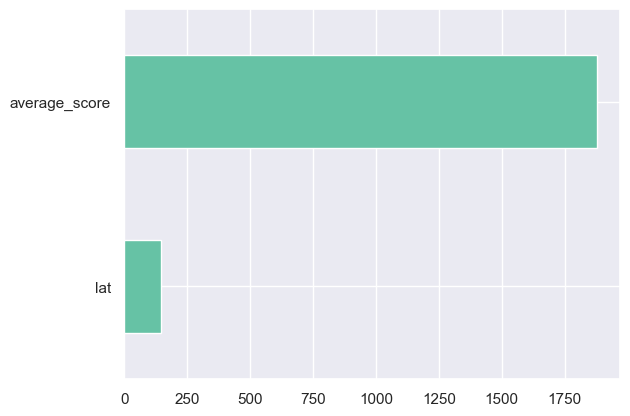

In [96]:
y=y.astype('int')

...
from sklearn.feature_selection import chi2 # хи-квадрат

imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

<Axes: >

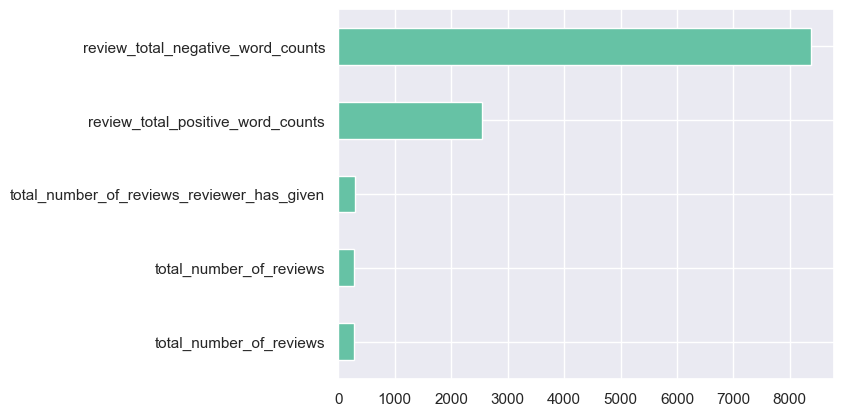

In [97]:
from sklearn.feature_selection import f_classif # anova

imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

# Работа с числовыми признаками

In [98]:
# загружаем необходимые библиотеки

from scipy import stats
import statsmodels.api as sm
from statsmodels import stats as sms

import matplotlib.pyplot as plt
import seaborn as sns

# делаем визуальную настройку графиков
sns.set_theme("notebook") 
sns.set_palette("Set2") 

## Признак average_score

In [99]:
hotels['average_score'].nunique()

34

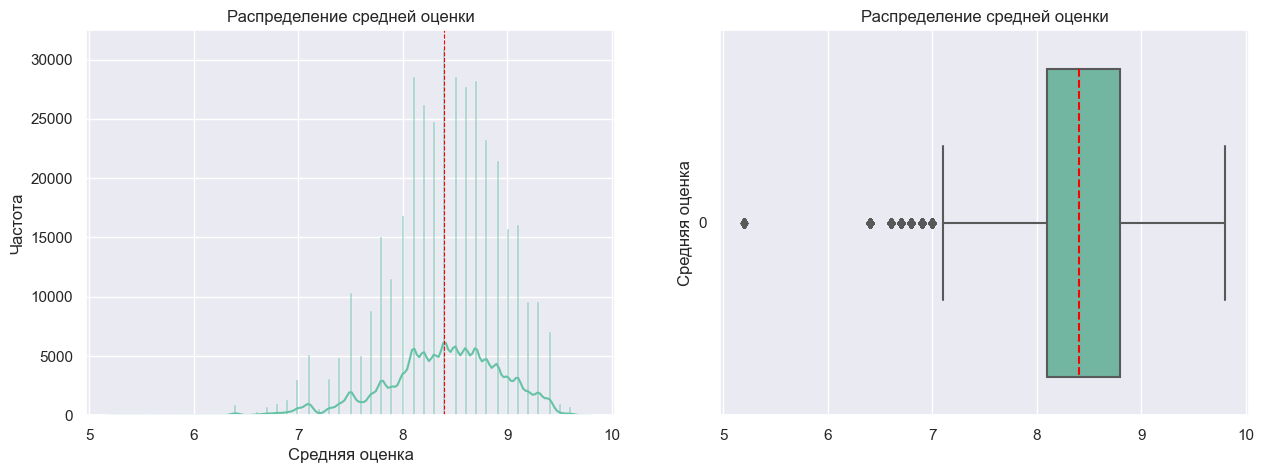

In [100]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(hotels['average_score'], kde=True, ax=axes[0])
axes[0].set(xlabel='Средняя оценка', ylabel='Частота')
axes[0].set_title('Распределение средней оценки')
axes[0].axvline(hotels['average_score'].mean(), color='red', linestyle='--', linewidth=0.8)

sns.boxplot(hotels['average_score'], ax=axes[1], orient='h', medianprops={"color": "red", "linestyle": '--'})
axes[1].set(ylabel='Средняя оценка')
axes[1].set_title('Распределение средней оценки')

plt.show()

Распределение признака напоминает нормальное, поэтому стандартизируем его

In [144]:
#STANDARDSCALER

#Для стандартизации используем класс StandardScaler.

s_scaler = preprocessing.StandardScaler()
hotels_2 = pd.DataFrame(hotels['average_score']) 
score_s= s_scaler.fit_transform(hotels_2) 
score_s = pd.DataFrame(score_s, columns=['score_stand'])
hotels = pd.concat([hotels, score_s], axis=1)
hotels.shape


KeyError: 'average_score'

In [102]:
# Удаляем столбец average_score, oставляем стандартизированные данные
hotels.drop(['average_score'], axis = 1, inplace = True)
hotels.head()

,hotel_address,additional_number_of_scoring,review_date,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng,score_stand
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671,0.005054
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097,-0.177467
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643,0.917663
3,216 Avenue Jean Jaures 19th arr 75019 Paris Fr...,34,9/22/2015,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotles...,11,8,10.0,"[' Leisure trip ', ' Solo traveler ', ' Standa...",681 day,48.888697,2.39454,-1.637641
4,Molenwerf 1 1014 AG Amsterdam Netherlands,914,3/5/2016,Golden Tulip Amsterdam West,Poland,Torn sheets,4,7586,The staff was very friendly and helpful Break...,20,10,9.6,"[' Business trip ', ' Couple ', ' Standard Dou...",516 day,52.385601,4.84706,0.187576


In [103]:
hotels['review_total_negative_word_counts'].nunique()

402

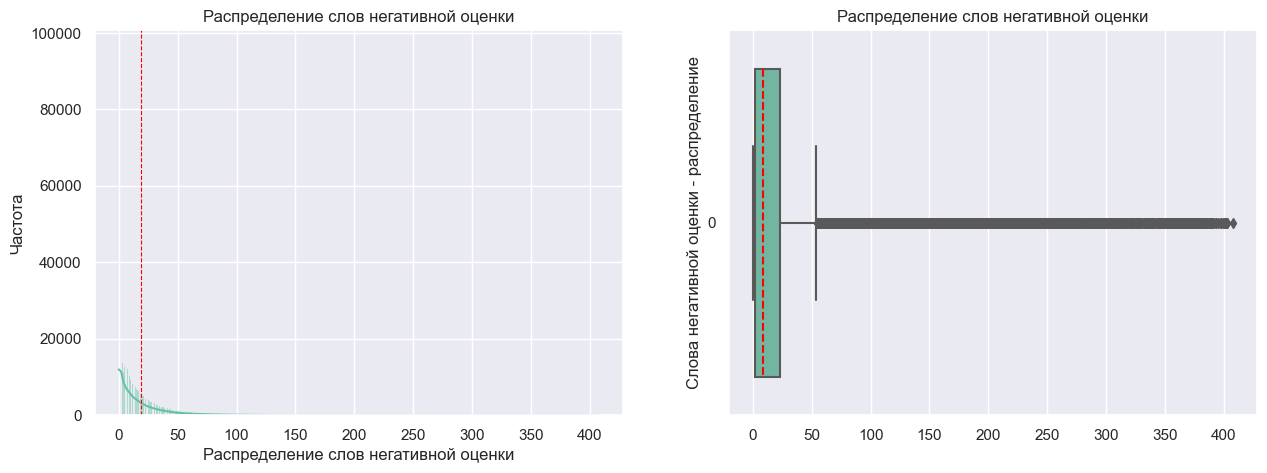

In [104]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(hotels['review_total_negative_word_counts'], kde=True, ax=axes[0])
axes[0].set(xlabel='Распределение слов негативной оценки', ylabel='Частота')
axes[0].set_title('Распределение слов негативной оценки')
axes[0].axvline(hotels['review_total_negative_word_counts'].mean(), color='red', linestyle='--', linewidth=0.8)

sns.boxplot(hotels['review_total_negative_word_counts'], ax=axes[1], orient='h', medianprops={"color": "red", "linestyle": '--'})
axes[1].set(ylabel='Слова негативной оценки - распределение')
axes[1].set_title('Распределение слов негативной оценки')

plt.show()

Распределение признака отличается от нормального, есть много выбросов, поэтому нормализуем его с помощью RobustScaler

In [105]:

# инициализируем нормализатор RobustScaler

s_scaler = preprocessing.RobustScaler()
hotels_3 = pd.DataFrame(hotels['review_total_negative_word_counts']) 
score_n= s_scaler.fit_transform(hotels_3) 
score_n = pd.DataFrame(score_n, columns=['negative_words_norm'])
hotels = pd.concat([hotels, score_n], axis=1)
hotels.shape

(386803, 18)

In [106]:
# Удаляем столбец review_total_negative_word_counts, oставляем нормализованные данные
hotels.drop(['review_total_negative_word_counts'], axis = 1, inplace = True)
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   hotel_name                                  386803 non-null  object 
 4   reviewer_nationality                        386803 non-null  object 
 5   negative_review                             386803 non-null  object 
 6   total_number_of_reviews                     386803 non-null  int64  
 7   positive_review                             386803 non-null  object 
 8   review_total_positive_word_counts           386803 non-null  int64  
 9   total_number_of_reviews_reviewer_has_given  386803 non-null  int64  
 

In [47]:
hotels['review_total_positive_word_counts'].nunique()

354

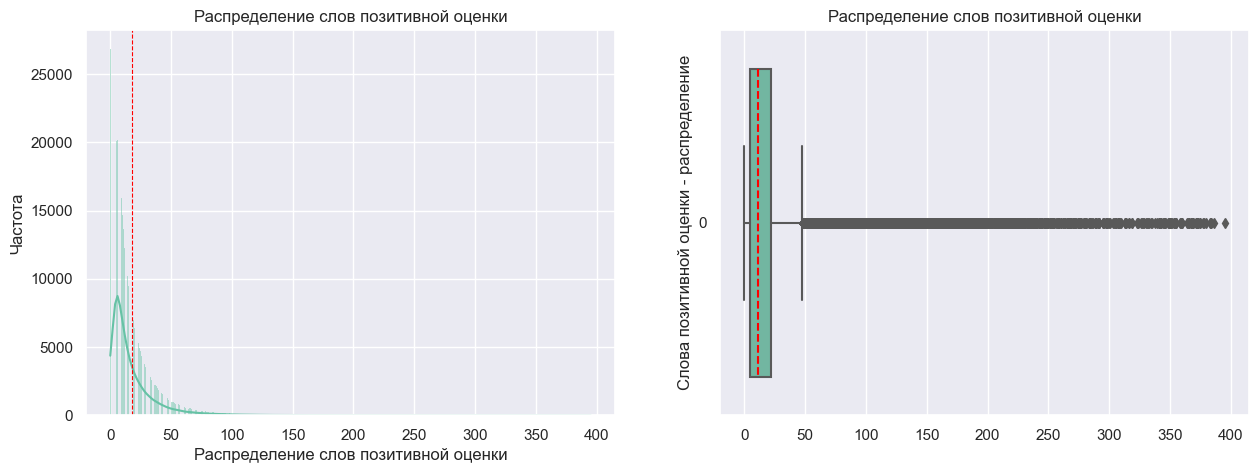

In [107]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(hotels['review_total_positive_word_counts'], kde=True, ax=axes[0])
axes[0].set(xlabel='Распределение слов позитивной оценки', ylabel='Частота')
axes[0].set_title('Распределение слов позитивной оценки')
axes[0].axvline(hotels['review_total_positive_word_counts'].mean(), color='red', linestyle='--', linewidth=0.8)

sns.boxplot(hotels['review_total_positive_word_counts'], ax=axes[1], orient='h', medianprops={"color": "red", "linestyle": '--'})
axes[1].set(ylabel='Слова позитивной оценки - распределение')
axes[1].set_title('Распределение слов позитивной оценки')

plt.show()

Распределение признака отличается от нормального, есть много выбросов, поэтому нормализуем его с помощью RobustScaler

In [108]:
# инициализируем нормализатор RobustScaler

s_scaler = preprocessing.RobustScaler()
hotels_4 = pd.DataFrame(hotels['review_total_positive_word_counts']) 
score_p= s_scaler.fit_transform(hotels_4) 
score_p = pd.DataFrame(score_p, columns=['positive_words_norm'])
hotels = pd.concat([hotels, score_p], axis=1)
hotels.shape

(386803, 18)

In [109]:
# Удаляем столбец review_total_positive_word_counts, oставляем нормализованные данные
hotels.drop(['review_total_positive_word_counts'], axis = 1, inplace = True)
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   hotel_name                                  386803 non-null  object 
 4   reviewer_nationality                        386803 non-null  object 
 5   negative_review                             386803 non-null  object 
 6   total_number_of_reviews                     386803 non-null  int64  
 7   positive_review                             386803 non-null  object 
 8   total_number_of_reviews_reviewer_has_given  386803 non-null  int64  
 9   reviewer_score                              386803 non-null  float64
 

In [49]:
hotels['total_number_of_reviews'].nunique()

1142

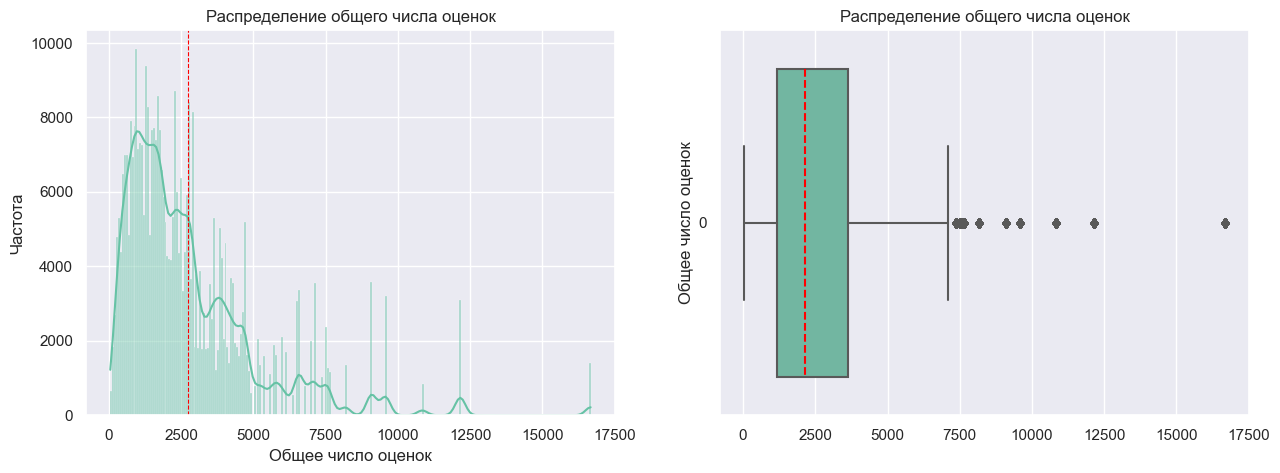

In [110]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(hotels['total_number_of_reviews'], kde=True, ax=axes[0])
axes[0].set(xlabel='Общее число оценок', ylabel='Частота')
axes[0].set_title('Распределение общего числа оценок')
axes[0].axvline(hotels['total_number_of_reviews'].mean(), color='red', linestyle='--', linewidth=0.8)

sns.boxplot(hotels['total_number_of_reviews'], ax=axes[1], orient='h', medianprops={"color": "red", "linestyle": '--'})
axes[1].set(ylabel='Общее число оценок')
axes[1].set_title('Распределение общего числа оценок')

plt.show()

Распределение признака отличается от нормального, есть много выбросов, поэтому нормализуем его с помощью RobustScaler

In [111]:
# инициализируем нормализатор RobustScaler

s_scaler = preprocessing.RobustScaler()
hotels_5 = pd.DataFrame(hotels['total_number_of_reviews']) 
score_t= s_scaler.fit_transform(hotels_5) 
score_t = pd.DataFrame(score_t, columns=['total_reviews_norm'])
hotels = pd.concat([hotels, score_t], axis=1)
hotels.shape

(386803, 18)

In [112]:
# Удаляем столбец total_number_of_reviews, oставляем нормализованные данные
hotels.drop(['total_number_of_reviews'], axis = 1, inplace = True)
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   hotel_name                                  386803 non-null  object 
 4   reviewer_nationality                        386803 non-null  object 
 5   negative_review                             386803 non-null  object 
 6   positive_review                             386803 non-null  object 
 7   total_number_of_reviews_reviewer_has_given  386803 non-null  int64  
 8   reviewer_score                              386803 non-null  float64
 9   tags                                        386803 non-null  object 
 

In [51]:
hotels['total_number_of_reviews_reviewer_has_given'].nunique()

194

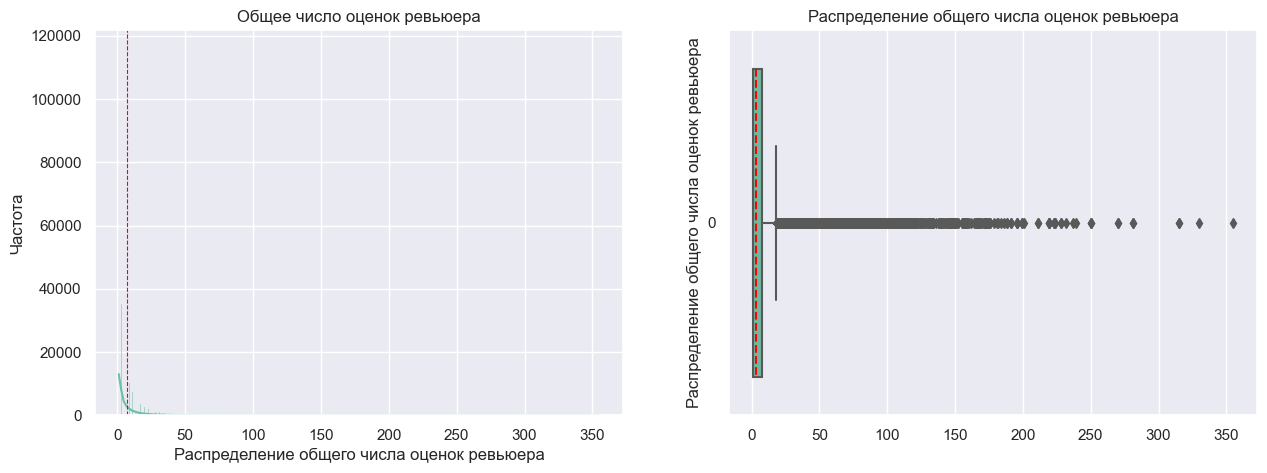

In [113]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(hotels['total_number_of_reviews_reviewer_has_given'], kde=True, ax=axes[0])
axes[0].set(xlabel='Распределение общего числа оценок ревьюера', ylabel='Частота')
axes[0].set_title('Общее число оценок ревьюера')
axes[0].axvline(hotels['total_number_of_reviews_reviewer_has_given'].mean(), color='red', linestyle='--', linewidth=0.8)

sns.boxplot(hotels['total_number_of_reviews_reviewer_has_given'], ax=axes[1], orient='h', medianprops={"color": "red", "linestyle": '--'})
axes[1].set(ylabel='Распределение общего числа оценок ревьюера')
axes[1].set_title('Распределение общего числа оценок ревьюера')

plt.show()

Распределение признака отличается от нормального, есть много выбросов, поэтому нормализуем его с помощью RobustScaler

In [114]:
# инициализируем нормализатор RobustScaler

s_scaler = preprocessing.RobustScaler()
hotels_6 = pd.DataFrame(hotels['total_number_of_reviews_reviewer_has_given']) 
score_r= s_scaler.fit_transform(hotels_6) 
score_r = pd.DataFrame(score_r, columns=['review_reviewer_norm'])
hotels = pd.concat([hotels, score_r], axis=1)
hotels.shape

(386803, 18)

In [115]:
# Удаляем столбец total_number_of_reviews_reviewer_has_given, oставляем нормализованные данные
hotels.drop(['total_number_of_reviews_reviewer_has_given'], axis = 1, inplace = True)
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   hotel_address                 386803 non-null  object 
 1   additional_number_of_scoring  386803 non-null  int64  
 2   review_date                   386803 non-null  object 
 3   hotel_name                    386803 non-null  object 
 4   reviewer_nationality          386803 non-null  object 
 5   negative_review               386803 non-null  object 
 6   positive_review               386803 non-null  object 
 7   reviewer_score                386803 non-null  float64
 8   tags                          386803 non-null  object 
 9   days_since_review             386803 non-null  object 
 10  lat                           386803 non-null  object 
 11  lng                           386803 non-null  object 
 12  score_stand                   386803 non-nul

In [116]:
#Определяем количество уникальных отелей в базе
hotels['hotel_name'].nunique()

1492

In [117]:
#Преобразуем дату в другой формат
hotels['review_date'] = pd.to_datetime(hotels['review_date'])
hotels.sort_values(by='review_date', inplace = True)
hotels.head()
#hotels.dtypes

,hotel_address,additional_number_of_scoring,review_date,hotel_name,reviewer_nationality,negative_review,positive_review,reviewer_score,tags,days_since_review,lat,lng,score_stand,negative_words_norm,positive_words_norm,total_reviews_norm,review_reviewer_norm
143997,Prins Hendrikkade 108 Amsterdam City Center 10...,207,2015-08-04,Grand Hotel Amr th Amsterdam,United Kingdom,No Negative,We arrived early and taken straight to the ro...,10.0,"[' Leisure trip ', ' Group ', ' Deluxe Room ',...",730 day,52.374415,4.904144,-0.177467,-0.428571,1.117647,-0.246330,7.428571
86268,163 Marsh Wall Docklands Tower Hamlets London ...,2682,2015-08-04,Britannia International Hotel Canary Wharf,United Kingdom,The hotel is very tired and in need of a lot ...,The staff were friendly,5.8,"[' Leisure trip ', ' Couple ', ' Standard Doub...",730 day,51.50191,-0.023221,-2.367728,1.238095,-0.294118,2.835237,0.000000
159209,22 Hertsmere Road Tower Hamlets London E14 4ED...,930,2015-08-04,London Marriott Hotel West India Quay,United Kingdom,Our dinner took an hour to arrive we were giv...,The hotel was really well prepared for all th...,9.2,"[' Leisure trip ', ' Group ', ' Deluxe King or...",730 day,51.507271,-0.021121,0.917663,1.904762,1.647059,0.286297,-0.142857
217001,Via Senigallia 6 20161 Milan Italy,904,2015-08-04,Hotel Da Vinci,Switzerland,No Negative,Breakfast free parking location quiet decorat...,8.3,"[' Leisure trip ', ' Couple ', ' Double Room '...",730 day,45.533137,9.171102,-0.542511,-0.428571,-0.176471,5.928222,1.428571
28485,151 157 City Road Shoreditch Islington London ...,1471,2015-08-04,M by Montcalm Shoreditch London Tech City,United Kingdom,No Negative,Love the look and hi tech features of the who...,10.0,"[' Leisure trip ', ' Couple ', ' Deluxe Double...",730 day,51.527847,-0.088947,1.282706,-0.428571,1.588235,1.088091,0.714286


# Проектирование признаков

## Выделение признаков из самых популярных тэгов

In [118]:
# Посмотрим что у нас творится с тагами, какая информация там скрывается
tags = set()
tags_list = list()
for index, value in hotels['tags'].items():
        pre_tags = value
        pre_tags = pre_tags.replace('[', '').replace(']', '')
        pre_tags = pre_tags.replace("'", '')
        pre_tags = pre_tags.split(",")
        for i in pre_tags:
            tags.add(i.strip())
            tags_list.append(i.strip())

print("\nУникальное количество тэгов:" , len(tags))
print("\nВсего тэгов:" , len(tags_list))   


Уникальное количество тэгов: 2368

Всего тэгов: 1767522


In [119]:
# Посмотрим на самые популярные тэги
tags_series = pd.Series(
    data = tags_list,
    index = tags_list,
    name = 'tags_series'
)
print("\nTop 10 популярных тэгов:", "\n")
print(tags_series.value_counts()[:10]) 


Top 10 популярных тэгов: 

Leisure trip                      313593
Submitted from a mobile device    230778
Couple                            189212
Stayed 1 night                    145373
Stayed 2 nights                   100263
Solo traveler                      81235
Stayed 3 nights                    72000
Business trip                      61989
Group                              49088
Family with young children         45836
Name: tags_series, dtype: int64


In [120]:
# Посмотрим еще раз топ тэги. Топ 10 тагов имеют неплохое кол-во отзывов каждый, создадим
# отдельный признак по каждому из них .
tags_df = pd.DataFrame(set(tags_series.value_counts()[:10].index), columns = ['tags'])
#display(tags_df)

In [121]:
#Кодируем самые популярные тэги
for tag in set(tags_df.tags):
    tag_name = str(tag)
    hotels[tag_name] =  hotels['tags'].apply(lambda x: 1 if tag_name in x else 0)

## Создание признака из национальности ревьюера 

In [122]:
#Определение числа уникальных национальностей ревьюеров
hotels['reviewer_nationality'].nunique()

225

In [123]:
#Определяем самые часто встречающиеся национальности ревьюеров
nat_list = list(hotels['reviewer_nationality'])
#display(nat_list)
nat_series = pd.Series(
    data = nat_list,
    index = nat_list,
    name = 'nationalities'
)
print("\nTop 10 национальностей:", "\n")
print(nat_series.value_counts()[:10]) 


Top 10 национальностей: 

 United Kingdom               184033
 United States of America      26541
 Australia                     16239
 Ireland                       11126
 United Arab Emirates           7617
 Saudi Arabia                   6722
 Netherlands                    6608
 Switzerland                    6498
 Canada                         5984
 Germany                        5956
Name: nationalities, dtype: int64


In [124]:
# Топ 10 национальностей покрывают практически весь датафрейм, создадим
# отдельный признак по каждой из них.
nation_df = pd.DataFrame(set(nat_series.value_counts()[:10].index), columns = ['reviewer_nationality'])
#display(nation_df)

In [125]:
#Кодируем самые популярные национальности
for reviewer_nationality in set(nation_df.reviewer_nationality):
    nation_name = str(reviewer_nationality)
    hotels[nation_name] =  hotels['tags'].apply(lambda x: 1 if tag_name in x else 0)

In [126]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 386803 entries, 143997 to 315137
Data columns (total 37 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   hotel_address                   386803 non-null  object        
 1   additional_number_of_scoring    386803 non-null  int64         
 2   review_date                     386803 non-null  datetime64[ns]
 3   hotel_name                      386803 non-null  object        
 4   reviewer_nationality            386803 non-null  object        
 5   negative_review                 386803 non-null  object        
 6   positive_review                 386803 non-null  object        
 7   reviewer_score                  386803 non-null  float64       
 8   tags                            386803 non-null  object        
 9   days_since_review               386803 non-null  object        
 10  lat                             386803 non-null  ob

## Добавляем признак города и кодируем его по методу OneHot

In [127]:
#Функция для выделения уникальных названий городов и добавляем признак
def address_split(address):
    city_name = []
    city_name = address.split()[-2]
    return city_name

hotels['city_name'] = hotels['hotel_address'].apply(address_split)
hotels.shape



(386803, 38)

In [128]:
#Частота, с которой присутствуют города в базе
hotels['city_name'].value_counts(normalize = True)

United       0.508719
Barcelona    0.116680
Paris        0.115899
Amsterdam    0.111183
Vienna       0.075434
Milan        0.072086
Name: city_name, dtype: float64

In [129]:
import category_encoders as ce

encoder = ce.OneHotEncoder(cols=['city_name'])
cols = encoder.fit_transform(hotels[['city_name']])
hotels = pd.concat([hotels, cols], axis=1)
hotels.shape

(386803, 44)

## Добавляем признак месяца, в который написан отзыв

In [130]:
#Добавляем признак - номер месяца, в который написан отзыв
hotels['review_month'] = hotels['review_date'].dt.month
hotels['review_month'].value_counts(normalize=True)

8     0.098011
7     0.096020
5     0.089668
10    0.085242
6     0.083314
4     0.083280
9     0.082207
1     0.081468
3     0.079888
12    0.076817
2     0.074288
11    0.069795
Name: review_month, dtype: float64

## Добавляем признак - день недели, в который написан код

In [131]:
#Добавляем признак - день недели, в который оставлен отзыв
weekday = hotels['review_date'].dt.dayofweek
hotels['weekend'] = weekday.apply(lambda x: 1 if x ==5 or x == 6 else 0)

## Добавляем признак "возраста оценки", предварительно преобразовав его в числовой

In [132]:
#Преобразуем признак "возраста оценки в числовой"

def review_days(arg):
     arg_splitted = arg.split(' ')
     year_words = ['day', 'days']
     for index,item in enumerate(arg_splitted):
         if item in year_words:
             return int(arg_splitted[index-1])
hotels['review_days'] = hotels['days_since_review'].apply(review_days)         

In [133]:
hotels.head()
hotels.shape

(386803, 47)

In [134]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 386803 entries, 143997 to 315137
Data columns (total 47 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   hotel_address                   386803 non-null  object        
 1   additional_number_of_scoring    386803 non-null  int64         
 2   review_date                     386803 non-null  datetime64[ns]
 3   hotel_name                      386803 non-null  object        
 4   reviewer_nationality            386803 non-null  object        
 5   negative_review                 386803 non-null  object        
 6   positive_review                 386803 non-null  object        
 7   reviewer_score                  386803 non-null  float64       
 8   tags                            386803 non-null  object        
 9   days_since_review               386803 non-null  object        
 10  lat                             386803 non-null  ob

## Проверка мультиколлинеарности

C:\Users\Vladimir\AppData\Local\Temp\ipykernel_16624\4041817561.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(hotels.corr(), annot=True) # включаем отображение коэффициентов


<Axes: >

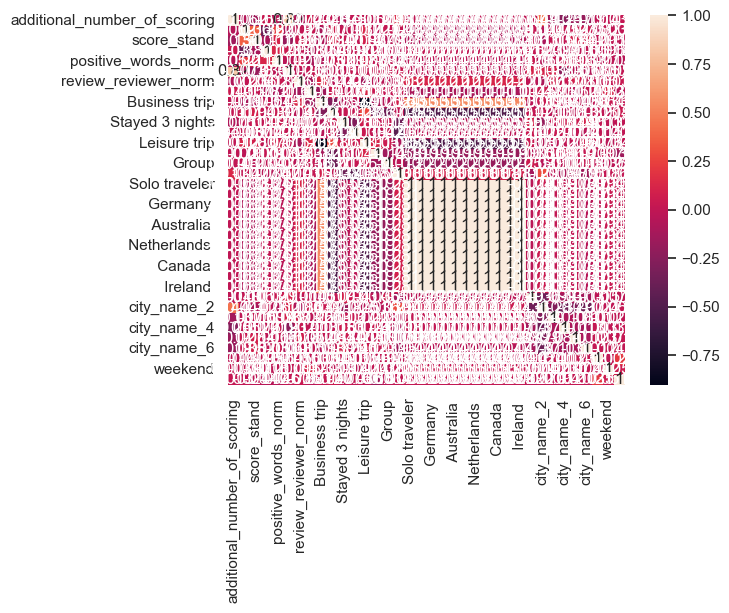

In [135]:
#Проведём корреляционный анализ датасета и используем для этого тепловую карту корреляций признаков.

import seaborn as sns # импортируем seaborn для построения графиков
sns.heatmap(hotels.corr(), annot=True) # включаем отображение коэффициентов

Таблица показывает высокую корреляцию ряда признаков, в особенности вновь созданных групповых признаков
(тэги, национальности, города).Но в данном случае, возможно, целесообразно их сохранить

# Продолжение расчета

In [136]:
#new_hotels = hotels.copy
hotels.drop(['hotel_address', 'review_date', 'hotel_name', 'reviewer_nationality', 'negative_review', 'positive_review', 'tags', 'days_since_review','lat', 'lng', 'city_name'], axis = 1, inplace = True)
hotels.head()

,additional_number_of_scoring,reviewer_score,score_stand,negative_words_norm,positive_words_norm,total_reviews_norm,review_reviewer_norm,Submitted from a mobile device,Business trip,Couple,...,Ireland,city_name_1,city_name_2,city_name_3,city_name_4,city_name_5,city_name_6,review_month,weekend,review_days
143997,207,10.0,-0.177467,-0.428571,1.117647,-0.246330,7.428571,0,0,0,...,0,1,0,0,0,0,0,8,0,730
86268,2682,5.8,-2.367728,1.238095,-0.294118,2.835237,0.000000,1,0,1,...,0,0,1,0,0,0,0,8,0,730
159209,930,9.2,0.917663,1.904762,1.647059,0.286297,-0.142857,0,0,0,...,0,0,1,0,0,0,0,8,0,730
217001,904,8.3,-0.542511,-0.428571,-0.176471,5.928222,1.428571,0,0,1,...,0,0,0,1,0,0,0,8,0,730
28485,1471,10.0,1.282706,-0.428571,1.588235,1.088091,0.714286,0,0,1,...,0,0,1,0,0,0,0,8,0,730


In [137]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 386803 entries, 143997 to 315137
Data columns (total 36 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   additional_number_of_scoring    386803 non-null  int64  
 1   reviewer_score                  386803 non-null  float64
 2   score_stand                     386803 non-null  float64
 3   negative_words_norm             386803 non-null  float64
 4   positive_words_norm             386803 non-null  float64
 5   total_reviews_norm              386803 non-null  float64
 6   review_reviewer_norm            386803 non-null  float64
 7   Submitted from a mobile device  386803 non-null  int64  
 8   Business trip                   386803 non-null  int64  
 9   Couple                          386803 non-null  int64  
 10  Stayed 3 nights                 386803 non-null  int64  
 11  Stayed 2 nights                 386803 non-null  int64  
 12  Leisure tri

In [138]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
X = hotels.drop(['reviewer_score'], axis = 1)  
y = hotels['reviewer_score'] 

In [139]:
# Загружаем специальный инструмент для разбивки:  
from sklearn.model_selection import train_test_split  

In [140]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [141]:
# Импортируем необходимые библиотеки:  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  
  
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)  


In [142]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.13633837578143704


Небольшой бонус:


In [10]:
# # убираем признаки которые еще не успели обработать, 
# # модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
# object_columns = [s for s in hotels.columns if hotels[s].dtypes == 'object']
# hotels.drop(object_columns, axis = 1, inplace=True)

# # заполняем пропуски самым простым способом
# hotels = hotels.fillna(0)